In [1]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from scipy.ndimage import gaussian_filter1d
from wfOpto import *

In [120]:
data = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [121]:
def powerDep3Pow(ax,data,ylim):
    colors=['deepskyblue','dodgerblue','mediumblue']
    powers = np.array([0.2,1.7,3])
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(data.laserPowers == power).ravel()
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)
        for c,iP in enumerate(pxPowers):
            iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color=colors[c])
        plt.fill_between(timestamps, \
                 np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
                 np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.3,linewidth=0)
        plt.legend(['0.07 mW', '0.63 mW', '1.1 mW'], loc='upper right',bbox_to_anchor=(1.2,1))
        plt.xlabel('Time (ms)')
        plt.ylabel('Brain Activity ($\Delta F$/F)')
        plt.title('Inactivation 3 Powers')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
        plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')
        plt.ylim(ylim)
    

<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_2008\173386258.py:33: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Brain Activity ($\Delta F$/F)')


In [122]:
def powerDepAllPow(ax,data,ylim):
    powers = np.unique(laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(data.laserPowers == power).ravel()
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

        for iP in pxPowers:
            iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP, axis=0),color='k')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
        plt.xlabel('time (ms)')
        plt.title('Inactivation All Powers')
        plt.ylim(ylim)

In [123]:
def powerQuant(ax,data):
    powers = np.unique(data.laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(data.laserPowers == power).ravel()
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(90)

    timeMean = np.mean(time90, axis=1)
    plt.plot(powers,timeMean,'-o',c='k',lw=2)
    plt.errorbar(powers,timeMean,yerr=.8,c='k')
    plt.scatter(powers,timeMean)
    plt.xlabel("Laser powers (mW)")
    plt.title("Inactivation at Peak (90 ms)")

## Power:Inactivation figs

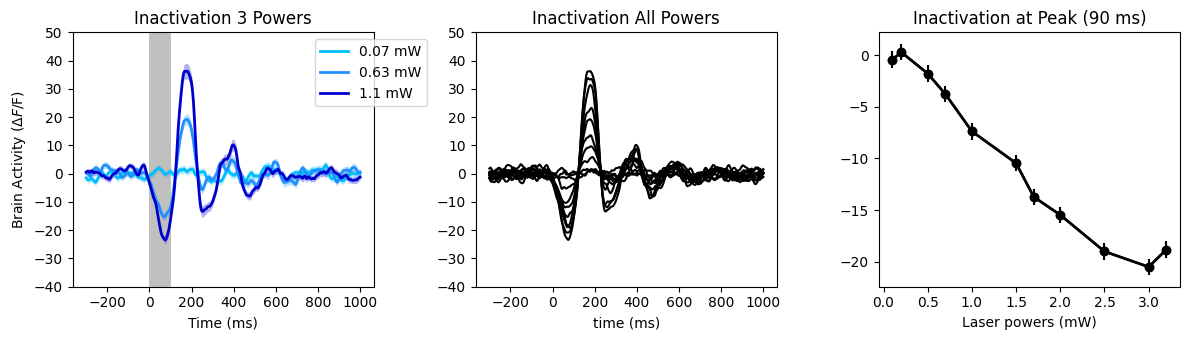

In [127]:
f = plt.figure(figsize=(12, 3.5))
gs = mpl.gridspec.GridSpec(1, 3)

ylim=[-40,50]
ax = plt.subplot(gs[0])
powerDep3Pow(ax,data,ylim)

ax = plt.subplot(gs[1])
powerDepAllPow(ax,data,ylim)

ax = plt.subplot(gs[2])
powerQuant(ax,data)

f.tight_layout()

In [128]:
mouse='AB_0032'
date="4.25"

In [131]:
f.savefig(f'C:/GitHub/steinmetzlab/wf + opto/figs/opto/{mouse}powDep_{date}.png')

## Stim Length figs

In [133]:
data=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-05-23\1'))

In [149]:
serverPath = Path(r'Y:\Subjects\AB_0032\2024-05-21\1')
timeFile = serverPath / 'cameraFrameTimes.npy'
frameTimes = np.squeeze(np.load(timeFile))[::2] # every other frame - we want blue only
svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat = np.load(serverPath / 'blue/svdSpatialComponents.npy')
svdSpatFull = svdSpat[:,:,:500]

meanImage = np.load(serverPath / 'blue/meanImage.npy')
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
laserPowers = np.squeeze(np.load(serverPath /'laserPowers.npy'))
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
px, py, ncomps = svdSpatFull.shape

svdSpat = svdSpatFull.reshape(px*py, ncomps)

In [150]:
tToWf = scipy.interpolate.interp1d(frameTimes[:(svdTemp.shape[0])], svdTemp, axis=0, fill_value='extrapolate')
spatial = svdSpatFull.reshape(560*560,-1)

In [151]:
pulseLengths = []
for count,time in enumerate(laserOff):
    length = laserOff[count]-laserOn[count]
    length = round(length,2)
    pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)

In [148]:
np.unique(pulseLengths)

array([0.1])

In [142]:
svdTemp.shape

(70943, 500)

In [143]:
frameTimes.shape

(118378,)

In [134]:
def stimDepPow(ax,ylim,data,pow):
    lens = np.unique(data.pulseLengths)
    power=pow
    pws=np.argwhere(data.laserPowers==power).ravel()
    pixel = (198, 246)
    pxLen = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))
    for iP, len in enumerate(lens):
        lenTrs = np.argwhere(data.pulseLengths == len).ravel()
        theseTrs=np.intersect1d(lenTrs,pws)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisLen = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisLen.append(mov)
        thisLen = np.array(thisLen)
        pxLen.append(thisLen)
    pxLen=np.array(pxLen)

    for iP in pxLen:
        iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP,axis=0),color='k')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$/F')
    plt.title('temporal resolution over laser durations')
    plt.ylim(ylim)

<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_2008\3161012557.py:34: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$/F')


In [135]:
def stimDepPowMod(ax,ylim,data,pow,lenList):
    colors=['deepskyblue','dodgerblue','mediumblue','indigo','violet','darkviolet','deeppink']
    power=pow
    pws=np.argwhere(data.laserPowers==power).ravel()
    lens = lenList
    pixel = (198, 246)
    pxLens = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))

    for iP, len in enumerate(lens):
        lenTrs = np.argwhere(data.pulseLengths == len).ravel()
        theseTrs=np.intersect1d(lenTrs,pws)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisLen = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisLen.append(mov)
        thisLen = np.array(thisLen)
        pxLens.append(thisLen)
    for c,iP in enumerate(pxLens):
        iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color=colors[c])
        # plt.fill_between(timestamps, \
        #         np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
        #         np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.3,linewidth=0)
    plt.legend(lens, loc='upper right',bbox_to_anchor=(1.2,1))
    plt.xlabel('Time (ms)')
    plt.title(f'{lenList.shape} Pulse Lengths')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.ylim(ylim)

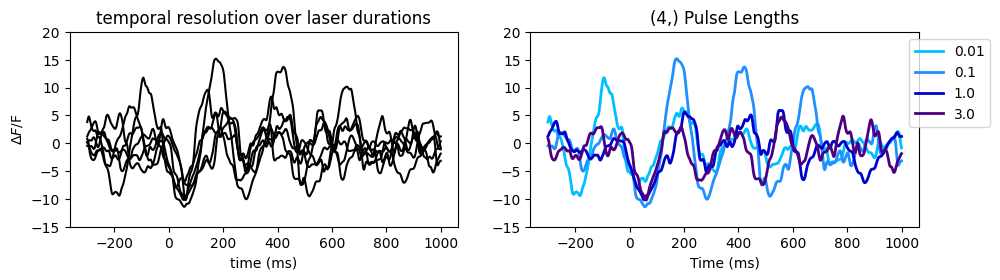

In [136]:
f = plt.figure(figsize=(14, 5))
gs = mpl.gridspec.GridSpec(2,3)
pow=.7
lenList=np.array([0.01,0.1,1,3])
ylim=[-15,20]

ax = plt.subplot(gs[0])
stimDepPow(ax,ylim,data,pow)

ax = plt.subplot(gs[1])
stimDepPowMod(ax,ylim,data,pow,lenList)

f.tight_layout()

<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_2008\2916904775.py:38: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$/F')


(25, 650)
(26, 650)
(25, 650)
(26, 650)
(25, 650)
(25, 650)


(-50.0, 50.0)

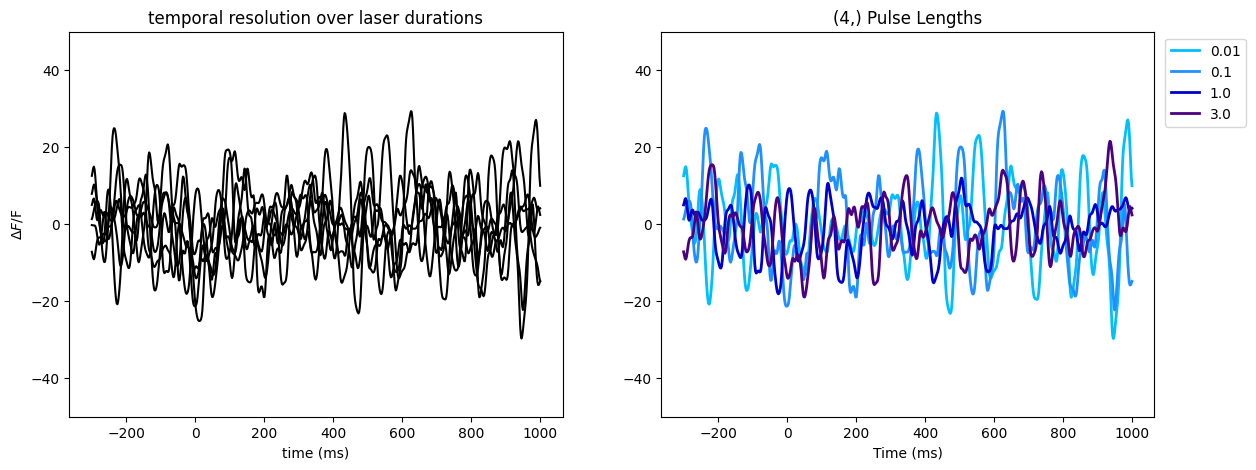

In [170]:
f = plt.figure(figsize=(14, 5))
gs = mpl.gridspec.GridSpec(1,2)
ylim=[-50,50]
lens = np.unique(pulseLengths)
power=pow
pws=np.argwhere(laserPowers==power).ravel()
pixel = (198, 246)
pxLen = []
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((246, 198), (py, px))
for iP, len in enumerate(lens):
    lenTrs = np.argwhere(pulseLengths == len).ravel()
    theseTrs=np.intersect1d(lenTrs,pws)
    onTimes = laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisLen = []
    for iT, tr in enumerate(trs):
        wf = tToWf(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = svdSpat[pixel_ix] @ dwf
        thisLen.append(mov)
    thisLen = np.array(thisLen)
    print(thisLen.shape)
    pxLen.append(thisLen)
#pxLen=np.array(pxLen)

ax = plt.subplot(gs[0])
for iP in pxLen:
    iP = gaussian_filter1d(iP, sigma=2)
    plt.plot(timestamps, np.mean(iP,axis=0),color='k')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
plt.xlabel('time (ms)')
plt.ylabel('$\Delta F$/F')
plt.title('temporal resolution over laser durations')
plt.ylim(ylim)

############################################################ 
############# 3 powers ###############
###########################################################
colors=['deepskyblue','dodgerblue','mediumblue','indigo','violet','darkviolet','deeppink']
power=pow
pws=np.argwhere(laserPowers==power).ravel()
lens = lenList
pixel = (198, 246)
pxLens = []
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((246, 198), (py, px))

for iP, len in enumerate(lens):
    lenTrs = np.argwhere(pulseLengths == len).ravel()
    theseTrs=np.intersect1d(lenTrs,pws)
    onTimes = laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisLen = []
    for iT, tr in enumerate(trs):
        wf = tToWf(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = svdSpat[pixel_ix] @ dwf
        thisLen.append(mov)
    thisLen = np.array(thisLen)
    pxLens.append(thisLen)

ax = plt.subplot(gs[1])
for c,iP in enumerate(pxLens):
    iP = gaussian_filter1d(iP, sigma=2)
    plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color=colors[c])
    # plt.fill_between(timestamps, \
    #         np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
    #         np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.3,linewidth=0)
plt.legend(lens, loc='upper right',bbox_to_anchor=(1.2,1))
plt.xlabel('Time (ms)')
plt.title(f'{lenList.shape} Pulse Lengths')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
plt.ylim(ylim)

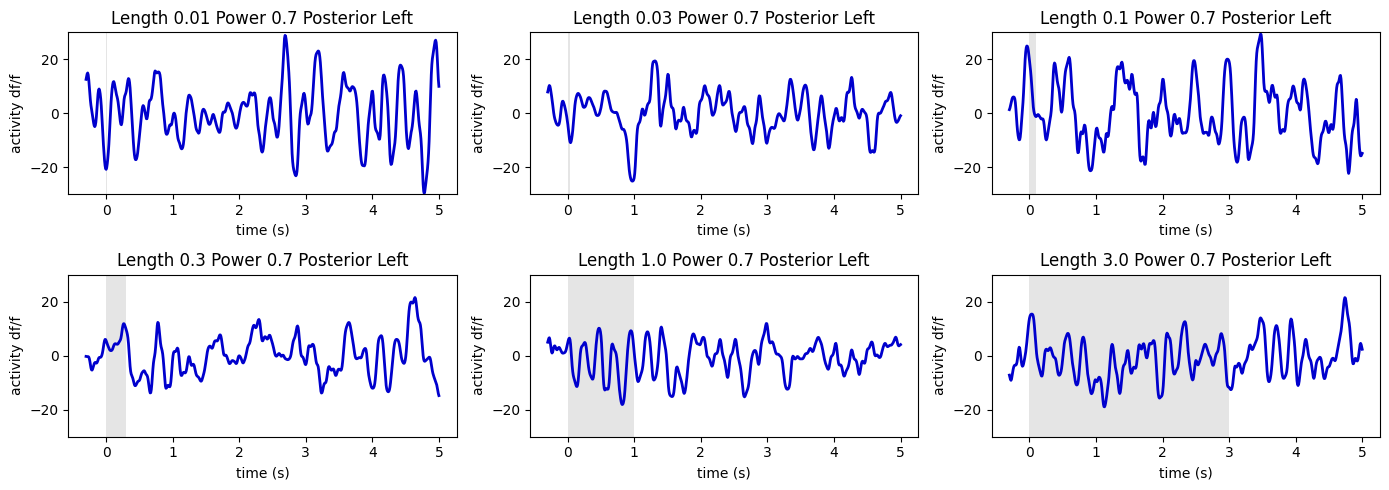

In [171]:
f = plt.figure(figsize=(14, 5))
gs = mpl.gridspec.GridSpec(2,3)

power=.7
pws=np.argwhere(laserPowers==power).ravel()
pixel = (198, 246)
n_samples = 650
timestamps = np.linspace(-0.3, 5, n_samples)
pixel_ix = np.ravel_multi_index((246, 198), (py, px))
for count,len in enumerate(np.unique(pulseLengths)):
    lenTrs = np.argwhere(pulseLengths == len).ravel()
    theseTrs=np.intersect1d(lenTrs,pws)
    onTimes = laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisLen = []
    for iT, tr in enumerate(trs):
        wf = tToWf(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = svdSpat[pixel_ix] @ dwf
        thisLen.append(mov)
    thisLen = np.array(thisLen)
    iP = gaussian_filter1d(thisLen, sigma=2)
    ax=plt.subplot(gs[count])
    plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color='mediumblue')
    plt.axvspan(0,len,color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.title(f'Length {len} Power {power} Posterior Left')
    plt.xlabel('time (s)')
    plt.ylabel('activity df/f')
    plt.ylim([-30,30])
f.tight_layout()

In [137]:
mouse='AL_0027'
date="4.18"

In [139]:
f.savefig(f'C:/GitHub/steinmetzlab/wf + opto/figs/opto/{mouse}stimLen_{date}.png')

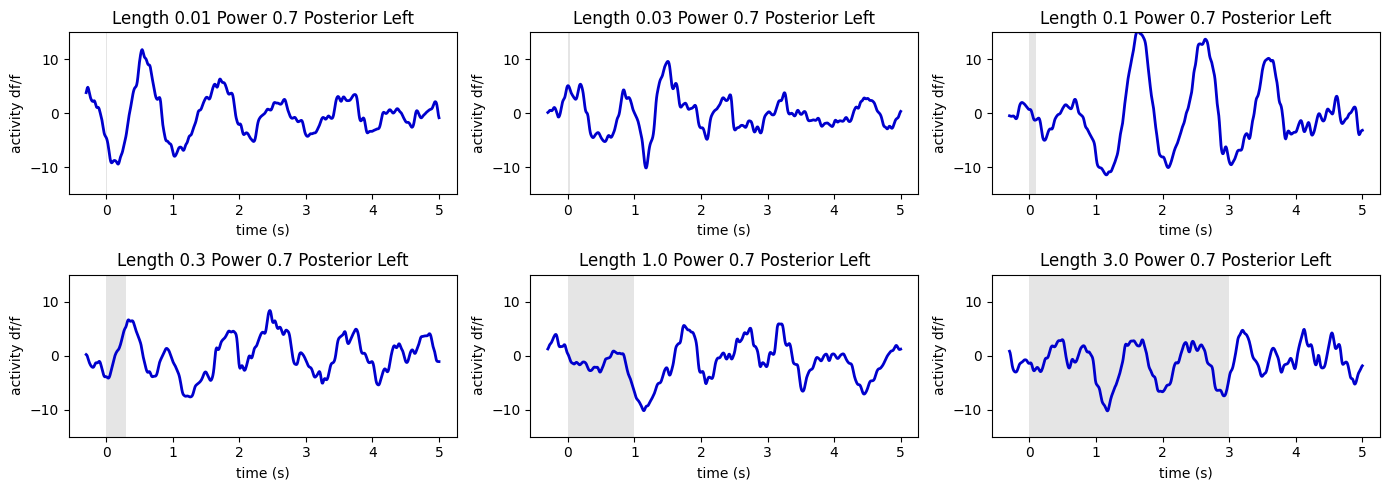

In [156]:
f = plt.figure(figsize=(14, 5))
gs = mpl.gridspec.GridSpec(2,3)

power=.7
pws=np.argwhere(data.laserPowers==power).ravel()
pixel = (198, 246)
n_samples = 650
timestamps = np.linspace(-0.3, 5, n_samples)
pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))
for count,len in enumerate(np.unique(data.pulseLengths)):
    lenTrs = np.argwhere(data.pulseLengths == len).ravel()
    theseTrs=np.intersect1d(lenTrs,pws)
    onTimes = data.laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisLen = []
    for iT, tr in enumerate(trs):
        wf = data.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = data.svdSpat[pixel_ix] @ dwf
        thisLen.append(mov)
    thisLen = np.array(thisLen)
    iP = gaussian_filter1d(thisLen, sigma=2)
    ax=plt.subplot(gs[count])
    plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color='mediumblue')
    plt.axvspan(0,len,color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.title(f'Length {len} Power {power} Posterior Left')
    plt.xlabel('time (s)')
    plt.ylabel('activity df/f')
    plt.ylim([-15,15])
f.tight_layout()

In [158]:
f.savefig(f'C:/GitHub/steinmetzlab/wf + opto/figs/opto/{mouse}allstimlen_{date}.png')

## Visresp figs

In [64]:
dataFlicker=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-04-28\1'))

In [93]:
serverPath = Path(r'Y:\Subjects\AL_0032\2024-04-27\1')
timeFile = serverPath / 'cameraFrameTimes.npy'
frameTimes = np.squeeze(np.load(timeFile))[::2] # every other frame - we want blue only
svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat = np.load(serverPath / 'blue/svdSpatialComponents.npy')
svdSpatFull = svdSpat[:,:,:500]

meanImage = np.load(serverPath / 'blue/meanImage.npy')
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
laserPowers = np.squeeze(np.load(serverPath /'laserPowers.npy'))
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
px, py, ncomps = svdSpatFull.shape

svdSpat = svdSpatFull.reshape(px*py, ncomps)

In [103]:
tToWf = scipy.interpolate.interp1d(frameTimes[:70943], svdTemp, axis=0, fill_value='extrapolate')
spatial = svdSpatFull.reshape(560*560,-1)

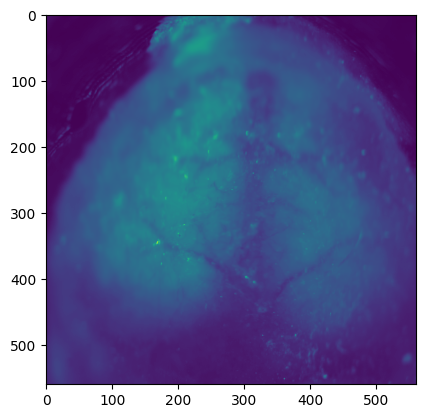

In [107]:
plt.imshow(meanImage)

In [106]:
print(np.unique(laserPowers))
print(np.unique(galvoX))
print(np.unique(galvoY))

[0.1 0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]
[-0.]
[-0.   1.5  2.5]


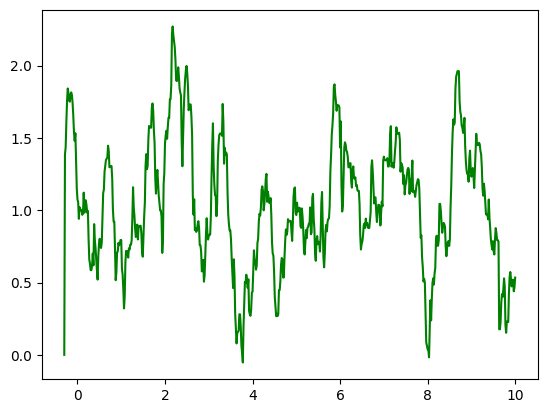

In [117]:
power = 3
pixel = (200, 350)
n_samples = 650
timestamps = np.linspace(-0.3, 10, n_samples)
locs=np.argwhere(galvoY==0).ravel()

pixel_ix = np.ravel_multi_index((350, 200), (py, px))
pows = np.argwhere(laserPowers == power).ravel()
times=np.intersect1d(pows,locs)
onTimes = laserOn[times]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

noFlicker = []
for iT, tr in enumerate(trs):
    wf = tToWf(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = svdSpat[pixel_ix] @ dwf
    noFlicker.append(mov)
noFlicker = np.array(noFlicker)

plt.plot(timestamps, np.mean(noFlicker, axis=0), color='green',label='no flicker')

Text(0.5, 1.0, '3 mW opto stim')

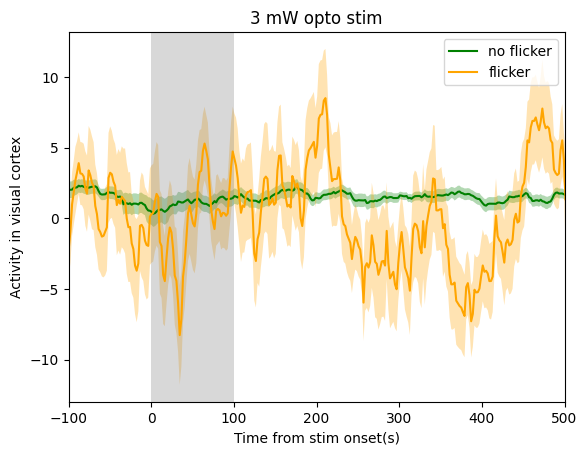

In [119]:
# process flicker
power = 3
pixel = (200, 400)
n_samples = 650
timestamps = np.linspace(-0.3, 10, n_samples)

pixel_ix = np.ravel_multi_index((400, 200), (dataFlicker.py, dataFlicker.px))
pows = np.argwhere(dataFlicker.laserPowers[dataFlicker.listExps[0]] == power).ravel()
locs=np.argwhere(dataFlicker.galvoY==0).ravel()
times=np.intersect1d(locs,pows)
onTimes = dataFlicker.laserOn[times]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

flicker = []
for iT, tr in enumerate(trs):
    wf = dataFlicker.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = dataFlicker.svdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

# process no flicker
power = 3
pixel = (410, 428)
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((400, 200), (py, px))
pows = np.argwhere(laserPowers == power).ravel()
locs=np.argwhere(dataFlicker.galvoY==-0).ravel()
times=np.intersect1d(locs,pows)
onTimes = dataFlicker.laserOn[times]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

noFlicker = []
for iT, tr in enumerate(trs):
    wf = tToWf(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = svdSpat[pixel_ix] @ dwf
    noFlicker.append(mov)
noFlicker = np.array(noFlicker)

plt.plot(timestamps, np.mean(noFlicker, axis=0), color='green',label='no flicker')
plt.fill_between(timestamps, \
                    np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                    np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color='green', alpha=0.3, lw=0, label='_nolegend_')

plt.plot(timestamps, np.mean(flicker,axis=0),color='orange',label='flicker')
plt.fill_between(timestamps, \
                    np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                    np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color='orange', lw=0, label='_nolegend_', alpha=0.3)
plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
plt.legend()
plt.xlim([-100,500])
plt.xlabel('Time from stim onset(s)')
plt.ylabel('Activity in visual cortex')
plt.title(f'{power} mW opto stim')

In [87]:
noFlicker.shape

(0,)

In [ ]:
pow=3
visPow(ax,ylim,pow,dataFlicker,dataNo)

# visQuant

In [ ]:
mouse='AL_0027'
date="4/18"

In [ ]:
fig.savefig(f'C:\GitHub\steinmetzlab\wf + opto\figs\control\{mouse}_{date}')

## AL_0023

In [37]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-30\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]


In [38]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-30\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]


In [6]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-09\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[1. 4.]
[-0.]
[0.1 0.5 0.6 0.7]
[0.1]


In [8]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-11\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[1. 4.]
[-0.]
[0.1 0.5 1.  1.5 2.  2.5 3. ]
[0.1]


In [13]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-14\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[1. 4.]
[-0.]
[0.1 0.5 1.  1.5 2.  2.5 3. ]
[0.1]


In [14]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-15\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[1. 4.]
[-0.]
[1. 2. 3. 4. 5.]
[0.1]


In [15]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-23\3')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.   1.5  2.5]
[0.05 0.1  0.15 0.2  0.3  0.5  0.75 1.   1.5 ]
[0.1]


In [17]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-24\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.   1.5  2.5]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]


In [20]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-25\2')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.   1.5  2.5]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]


In [21]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-30\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]


## ZYE_0069

In [22]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-07-14\4')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[0.]
[0.]
[3.2]
[0.5]


In [40]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-07-14\6')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\Subjects\\ZYE_0069\\2023-07-14\\6\\galvoXPositions.npy'

In [29]:
# this one is messy since it switches halfway through
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-07-17\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.   3.3]
[0.]
[0.1 0.4 0.5 0.7 1.1 2.2 3.2]
[0.01 0.05 0.1  0.2  0.5 ]


In [31]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-07-19\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[0.  3.3]
[0.  3.3]
[0.5 1.  1.5 2.  3.2]
[0.1]


In [32]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-08-16\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.01 -0.  ]
[-0.01 -0.  ]
[0.1 0.2 0.5 0.7 1.  1.2 1.5 1.7 2. ]
[0.1]


In [35]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-08-22\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.]
[0.05 0.1  0.15 0.2  0.3  0.5  0.75 1.   1.5 ]
[0.1]


## AL_0027

In [36]:
serverPath = Path(r'Z:\Subjects\AL_0027\2023-10-24\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]
